# Covid - 19 fatalities predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

sns.set_style('darkgrid')


# geographical data visualization 
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# changing names of countries to alpha codes for better display
from pycountry_convert import country_name_to_country_alpha3 as country_conv

# modele
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.svm import SVR


# preprocess
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# metrics 
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

Using TensorFlow backend.


In [2]:
init_notebook_mode(connected=True) 

In [3]:
countries_EU = ['Belgium','Bulgaria','Czechia','Denmark','Germany','Estonia','Ireland',
             'Greece','Spain','France','Croatia','Italy','Cyprus','Latvia','Lithuania',
             'Luxembourg','Hungary','Malta','Netherlands','Austria','Portugal',
             'Romania','Slovenia','Slovakia','Finland','Sweden', 'Switzerland','Poland']

countries_EU_ISO = []
for country in countries_EU:
    countries_EU_ISO.append(country_conv(country))

# Data import and initial cleanup (Preparation)

### Data import

In [4]:
df_main = pd.read_csv('train.csv')

In [5]:
df_main.head()

Id County Province_State Country_Region  Population    Weight        Date  \
0   1    NaN            NaN    Afghanistan    27657145  0.058359  2020-01-23   
1   2    NaN            NaN    Afghanistan    27657145  0.583587  2020-01-23   
2   3    NaN            NaN    Afghanistan    27657145  0.058359  2020-01-24   
3   4    NaN            NaN    Afghanistan    27657145  0.583587  2020-01-24   
4   5    NaN            NaN    Afghanistan    27657145  0.058359  2020-01-25   

           Target  TargetValue  
0  ConfirmedCases          0.0  
1      Fatalities          0.0  
2  ConfirmedCases          0.0  
3      Fatalities          0.0  
4  ConfirmedCases          0.0

In [6]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879602 entries, 0 to 879601
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Id              879602 non-null  int64  
 1   County          798322 non-null  object 
 2   Province_State  832104 non-null  object 
 3   Country_Region  879602 non-null  object 
 4   Population      879602 non-null  int64  
 5   Weight          879602 non-null  float64
 6   Date            879602 non-null  object 
 7   Target          879602 non-null  object 
 8   TargetValue     879602 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 60.4+ MB


### Data clean-up

In [7]:
# Checking for null values
df_main.isnull().sum()

Id                    0
County            81280
Province_State    47498
Country_Region        0
Population            0
Weight                0
Date                  0
Target                0
TargetValue           0
dtype: int64

In [8]:
# deleting the null columns, we dont need them, all info is in the Country_region col
# deleting the Id column, we also don't need it, Id is prebuild into pandas
df_main.dropna(axis = 1, inplace = True)
df_main.drop(['Id'], axis=1, inplace=True)
df_main.drop(['Weight'], axis=1, inplace=True)
df_main.drop(['Population'], axis=1, inplace=True)

In [9]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879602 entries, 0 to 879601
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country_Region  879602 non-null  object 
 1   Date            879602 non-null  object 
 2   Target          879602 non-null  object 
 3   TargetValue     879602 non-null  float64
dtypes: float64(1), object(3)
memory usage: 26.8+ MB


In [10]:
# changing Country_region name into sth shorter (it functions for us as country)
df_main.rename(columns={'Country_Region':'Country'}, inplace = True)

### Adding country codes as another column

In [11]:
# country of Burma created problems due to name change, it was easiest to delete te countries not highly related
# to polish situation
df_main = df_main[df_main.Country != 'Burma']
df_main = df_main[df_main.Country != 'Congo (Brazzaville)']
df_main = df_main[df_main.Country != 'Congo (Kinshasa)']
df_main = df_main[df_main.Country != 'Cote d\'Ivoire']
df_main = df_main[df_main.Country != 'Diamond Princess']
df_main = df_main[df_main.Country != 'Holy See']
df_main = df_main[df_main.Country != 'Diamond Princess']
df_main = df_main[df_main.Country != 'MS Zaandam']
df_main = df_main[df_main.Country != 'Kosovo']
df_main = df_main[df_main.Country != 'Taiwan*']
df_main = df_main[df_main.Country != 'West Bank and Gaza']

#changing valuable countries names to other
df_main.replace(to_replace ='Korea, South', value ='Korea, Republic of', inplace = True)
df_main.replace(to_replace ='US', value ='United States of America', inplace = True)

In [12]:
df_main['Country_Code'] = df_main['Country'].apply(country_conv)

In [13]:
df_main.head()

Country        Date          Target  TargetValue Country_Code
0  Afghanistan  2020-01-23  ConfirmedCases          0.0          AFG
1  Afghanistan  2020-01-23      Fatalities          0.0          AFG
2  Afghanistan  2020-01-24  ConfirmedCases          0.0          AFG
3  Afghanistan  2020-01-24      Fatalities          0.0          AFG
4  Afghanistan  2020-01-25  ConfirmedCases          0.0          AFG

### Splitting data into ConfirmedCases and Fatalities datasets, so it is easier to work with 

In [14]:
df_cases = df_main[df_main['Target'] == 'ConfirmedCases']
df_fatal = df_main[df_main['Target'] == 'Fatalities']

df_cases.drop(['Target'], axis=1, inplace=True)
df_fatal.drop(['Target'], axis=1, inplace=True)

In [15]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438531 entries, 0 to 879600
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Country       438531 non-null  object 
 1   Date          438531 non-null  object 
 2   TargetValue   438531 non-null  float64
 3   Country_Code  438531 non-null  object 
dtypes: float64(1), object(3)
memory usage: 16.7+ MB


In [16]:
df_cases.head()

Country        Date  TargetValue Country_Code
0  Afghanistan  2020-01-23          0.0          AFG
2  Afghanistan  2020-01-24          0.0          AFG
4  Afghanistan  2020-01-25          0.0          AFG
6  Afghanistan  2020-01-26          0.0          AFG
8  Afghanistan  2020-01-27          0.0          AFG

In [17]:
df_fatal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438531 entries, 1 to 879601
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Country       438531 non-null  object 
 1   Date          438531 non-null  object 
 2   TargetValue   438531 non-null  float64
 3   Country_Code  438531 non-null  object 
dtypes: float64(1), object(3)
memory usage: 16.7+ MB


In [18]:
df_fatal.head()

Country        Date  TargetValue Country_Code
1  Afghanistan  2020-01-23          0.0          AFG
3  Afghanistan  2020-01-24          0.0          AFG
5  Afghanistan  2020-01-25          0.0          AFG
7  Afghanistan  2020-01-26          0.0          AFG
9  Afghanistan  2020-01-27          0.0          AFG

It is very good, both stes has identical sizes, so data seems to check up

## Dividing data into test and train


In [19]:
print(max(df_fatal['Date']))
print(max(df_cases['Date']))

2020-05-28
2020-05-28


In [20]:
print(min(df_fatal['Date']))


2020-01-23


Dates range from what is shown above, so the last week is going to be treated as testing data.

The divide is going to be done now, two sets of data are going to be created.

In [21]:
df_fatal_train = df_fatal[(df_fatal['Date']<='2020-05-20')]
df_fatal_test = df_fatal[(df_fatal['Date']>'2020-05-20')]

df_cases_train = df_cases[(df_cases['Date']<='2020-05-20')]
df_cases_test = df_cases[(df_cases['Date']>'2020-05-20')]

## Selecting EU coutries

In [22]:
df_cases_EU = df_cases[df_cases['Country'].isin(countries_EU)]
df_fatal_EU = df_fatal[df_fatal['Country'].isin(countries_EU)]

In [23]:
df_fatal_EU_train = df_fatal_EU[(df_fatal['Date']<='2020-05-20')]
df_fatal_EU_test = df_fatal_EU[(df_fatal['Date']>'2020-05-20')]

df_cases_EU_train = df_cases_EU[(df_cases['Date']<='2020-05-20')]
df_cases_EU_test = df_cases_EU[(df_cases['Date']>'2020-05-20')]

# Displaying data

### World map
Showing sum of deaths/cases, and average deaths/cases per day (from the day first infected appeared), this can hel in finding countries similar to Paland.

#### SUM

In [24]:
# creating temp dataset for charts
df_temp = df_fatal_train.groupby('Country_Code').sum()
data = dict(
        type = 'choropleth',
        locations = df_temp.index,
        z = df_temp['TargetValue'],
        text = df_temp.index,
        colorbar = {'title' : 'Covid-19 Fatal'},
        colorscale = 'Jet'
      ) 
layout = dict(
    title = 'Covid-19 Fatal cases',
    geo = dict(
        showframe = True,
        projection = {'type':'natural earth'}
    )
)

choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

In [25]:
# creating temp dataset for charts
df_temp = df_cases_train.groupby('Country_Code').sum()
data = dict(
        type = 'choropleth',
        locations = df_temp.index,
        z = df_temp['TargetValue'],
        text = df_temp.index,
        colorbar = {'title' : 'Covid-19 Cases'},
        colorscale = 'Jet'
      ) 
layout = dict(
    title = 'Covid-19 cases',
    geo = dict(
        showframe = True,
        projection = {'type':'natural earth'},
    )
)

choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

#### Europe only
Displaying whole world is missing the point, USA is changing the scale to much. We should mostly consider just the European countrises not only due to scale problems Due to the political and cultural differences the models created considering the closes copuntries may lead to the best results. 

The general approach to epidemy threw all Europe is quite similar, so teaching model on data from EU may yield good results.

In [26]:
# creating temp dataset for charts
df_temp = df_cases_train.groupby('Country_Code').sum()
data = dict(
        type = 'choropleth',
        locations = df_temp.index,
        z = df_temp['TargetValue'],
        text = df_temp.index,
        colorbar = {'title' : 'Covid-19 Cases'},
        colorscale = 'Jet'
      ) 
layout = dict(
    title = 'Covid-19 Fatal cases',
    geo = dict(
        scope = 'europe',
        showframe = True,
    )
)

choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

#### Just Europe data

In [27]:
# creating temp dataset for charts
df_temp = df_fatal_EU_train.groupby('Country_Code').sum()
data = dict(
        type = 'choropleth',
        locations = df_temp.index,
        z = df_temp['TargetValue'],
        text = df_temp.index,
        colorbar = {'title' : 'Covid-19 Cases'},
        colorscale = 'Jet'
      ) 
layout = dict(
    title = 'Covid-19 Fatal Cases SUM',
    width = 800,
    geo = dict(
        scope = 'europe',
        showframe = True,
    )
)

choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

In [28]:
# creating temp dataset for charts
df_temp = df_fatal_EU_train.groupby('Country_Code').mean()
data = dict(
        type = 'choropleth',
        locations = df_temp.index,
        z = df_temp['TargetValue'],
        text = df_temp.index,
        colorbar = {'title' : 'Covid-19 Cases'},
        colorscale = 'Jet'
      ) 
layout = dict(
    title = 'Covid-19 Fatal Cases MEAN',
    width = 800,
    geo = dict(
        scope = 'europe',
        showframe = True,
    )
)

choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

In [29]:
# creating temp dataset for charts
df_temp = df_cases_EU_train.groupby('Country_Code').sum()
data = dict(
        type = 'choropleth',
        locations = df_temp.index,
        z = df_temp['TargetValue'],
        text = df_temp.index,
        colorbar = {'title' : 'Covid-19 Cases'},
        colorscale = 'Jet'
      ) 
layout = dict(
    title = 'Covid-19 Cases SUM',
    width = 800,
    geo = dict(
        scope = 'europe',
        showframe = True,
    )
)

choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

In [30]:
# creating temp dataset for charts
df_temp = df_cases_EU_train.groupby('Country_Code').mean()
data = dict(
        type = 'choropleth',
        locations = df_temp.index,
        z = df_temp['TargetValue'],
        text = df_temp.index,
        colorbar = {'title' : 'Covid-19 Cases'},
        colorscale = 'Jet'
      ) 
layout = dict(
    title = 'Covid-19 Cases MEAN',
    width = 800,
    geo = dict(
        scope = 'europe',
        showframe = True,
    )
)

choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

Based on the maps observations it is clear that one should consider only several countries along Poland, due to similar sum of fatalities and cases, and probably similar distribution of fatalities.

['POL', 'SWE', 'FIN', 'ROU', 'AUT', 'CHE', 'NDL', 'IRL', 'PRT', 'CZE', 'HUN']

In [31]:
similar_PL = ['SWE', 'FIN', 'ROU', 'AUT', 'CHE', 'IRL', 'PRT', 'CZE', 'HUN', 'POL']

In [32]:
df_fatal_simPL = df_fatal_EU_train[df_fatal_EU_train['Country_Code'].isin(similar_PL)]

## Charts

#### Mean distribution charts

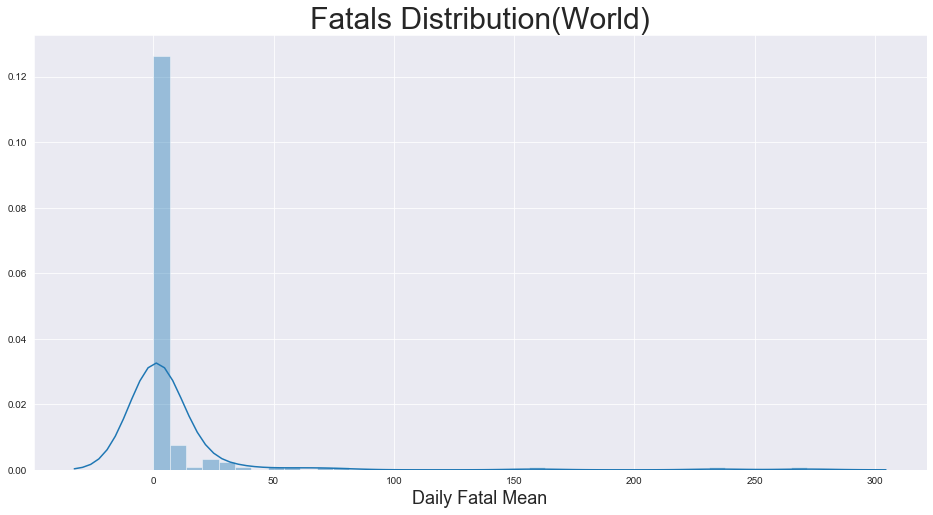

In [33]:
plt.figure(figsize=(16,8))
plt.title('Fatals Distribution(World)', fontsize=30)
plt.xlabel('Daily Fatal Mean', fontsize=18)
sns.distplot(df_fatal_train.groupby('Country_Code').mean(), bins=40)

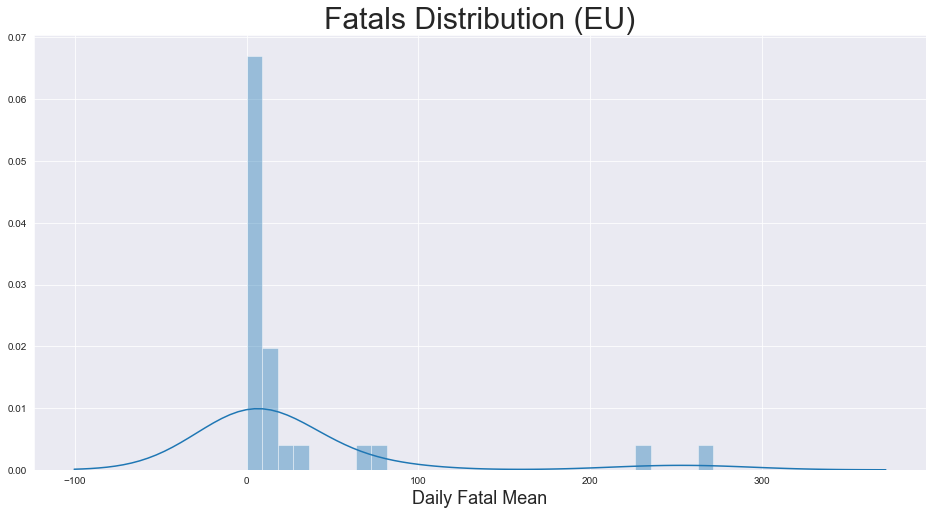

In [34]:
plt.figure(figsize=(16,8))
plt.title('Fatals Distribution (EU)', fontsize=30)
plt.xlabel('Daily Fatal Mean', fontsize=18)
sns.distplot(df_fatal_EU_train.groupby('Country_Code').mean(), bins=30)

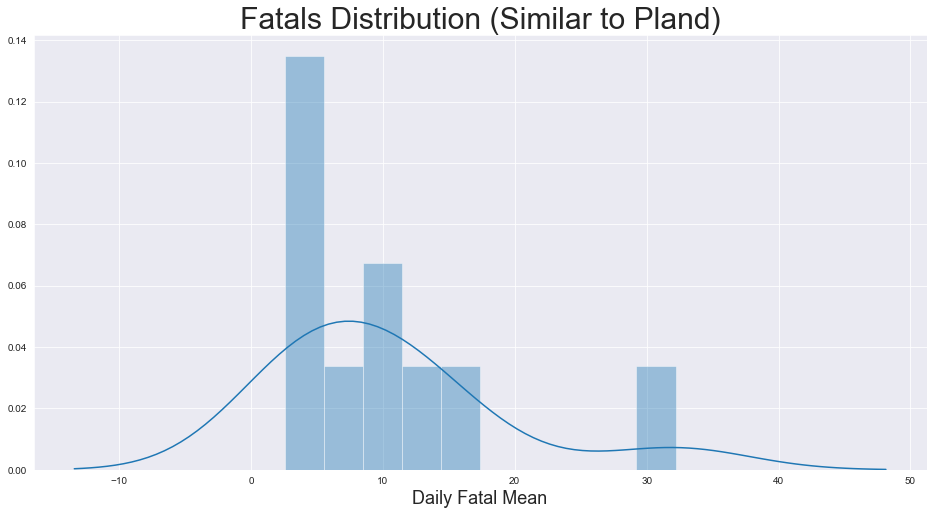

In [35]:
plt.figure(figsize=(16,8))
plt.title('Fatals Distribution (Similar to Pland)', fontsize=30)
plt.xlabel('Daily Fatal Mean', fontsize=18)
sns.distplot(df_fatal_simPL.groupby('Country_Code').mean(), bins=10)

### Sum distibution chart 

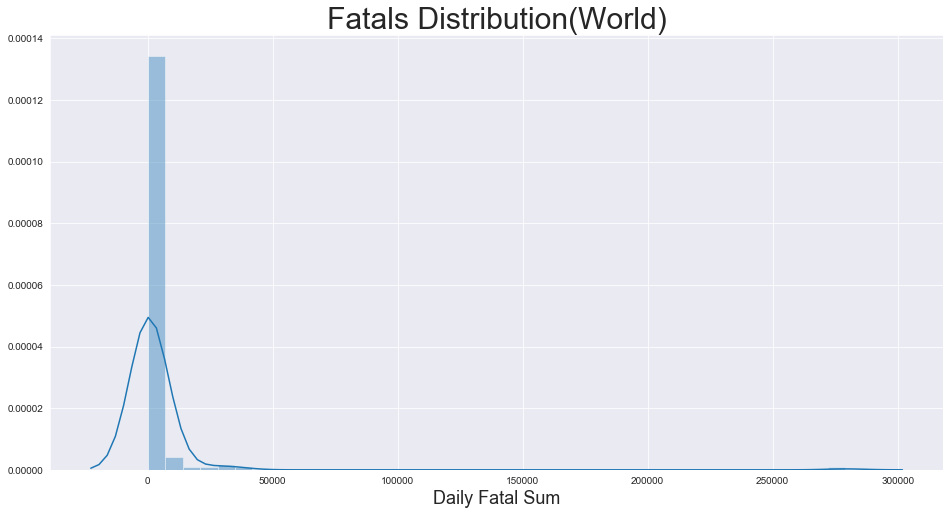

In [36]:
plt.figure(figsize=(16,8))
plt.title('Fatals Distribution(World)', fontsize=30)
plt.xlabel('Daily Fatal Sum', fontsize=18)
sns.distplot(df_fatal_train.groupby('Country_Code').sum(), bins=40)

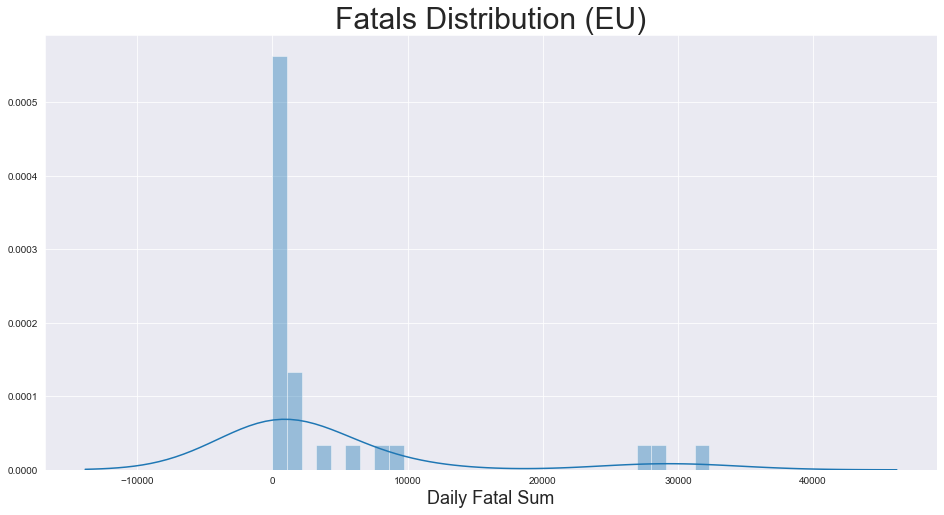

In [37]:
plt.figure(figsize=(16,8))
plt.title('Fatals Distribution (EU)', fontsize=30)
plt.xlabel('Daily Fatal Sum', fontsize=18)
sns.distplot(df_fatal_EU_train.groupby('Country_Code').sum(), bins=30)

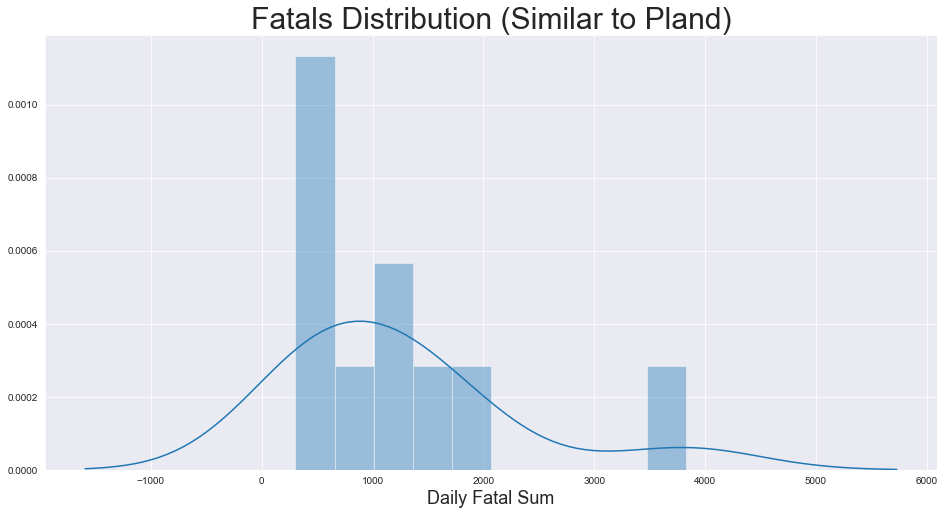

In [38]:
plt.figure(figsize=(16,8))
plt.title('Fatals Distribution (Similar to Pland)', fontsize=30)
plt.xlabel('Daily Fatal Sum', fontsize=18)
sns.distplot(df_fatal_simPL.groupby('Country_Code').sum(), bins=10)

One can seem that Poland is settled inside the highest spike, on every distribution plot, so it might be possible for neural network to find some numerical similarities between Poland and other countires, so defeniately the correct approach is to train network on all possible data, and later propagate this onto Polish case.

We should't be worried about the data from other countries, the algorith should be able to deferentiate between countries similar and not.

# Solution 
In the solution there will be presented to major approaches. SVM and LSTM networks will be tested on puerly Polish dataset, and later the better one will be used on all availible data. The better network will be run on four different sets: Polish, Similar_PL (countires politicaly and culturally similar to Poland), EU (all countries from europe) and all availible data.

I will try to show differences between approaches.

## Polish way
The way our country approached the pandemic is very diffrent from any other, without clasyfying the countries, using specialistic knowledge it is very hard to use data from there in learing. Thats why in this case we used only info from time series of poland, and ommited pices of info comming from abroad (this approach is very similar to single Stock Price Predictions).

In [39]:
# creating polish datasets
df_fatal_PL = df_fatal[df_fatal['Country'] == 'Poland']
df_cases_PL = df_cases[df_cases['Country'] == 'Poland']
# dropping country code
df_fatal_PL.drop(['Country_Code'], axis=1, inplace=True)
df_cases_PL.drop(['Country_Code'], axis=1, inplace=True)
# dropping country
df_fatal_PL.drop(['Country'], axis=1, inplace=True)
df_cases_PL.drop(['Country'], axis=1, inplace=True)

print(df_fatal_PL.shape)
print(df_cases_PL.shape)

(127, 2)
(127, 2)


In [40]:
# adding T column representing dates as iterative numbers
T = list(range(1,128))
df_fatal_PL['T'] = T
df_cases_PL['T'] = T

# Cumulative sum of cases in a day
df_fatal_PL['CSUM'] = np.cumsum(df_fatal_PL['TargetValue'])
df_cases_PL['CSUM'] = np.cumsum(df_cases_PL['TargetValue'])

### Sets division
sets are devided into train and test, test is representing the n days we want to predict onto. Later in the modeling process the train set will be devided into training and validation sets. The test set is being treated as uknown period.

In [41]:
df_fatal_PL_train = df_fatal_PL[(df_fatal_PL['Date']<='2020-05-10')]
df_fatal_PL_test = df_fatal_PL[(df_fatal_PL['Date']>'2020-05-10')]

df_cases_PL_train = df_cases_PL[(df_cases_PL['Date']<='2020-05-10')]
df_cases_PL_test = df_cases_PL[(df_cases_PL['Date']>'2020-05-10')]

print(df_fatal_PL_train.info())
print(df_fatal_PL_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 51817 to 52033
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         109 non-null    object 
 1   TargetValue  109 non-null    float64
 2   T            109 non-null    int64  
 3   CSUM         109 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 52035 to 52069
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         18 non-null     object 
 1   TargetValue  18 non-null     float64
 2   T            18 non-null     int64  
 3   CSUM         18 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 720.0+ bytes
None


In [42]:
print(df_fatal_PL_train)
print(df_fatal_PL_test)

train_samples = df_fatal_PL_train.shape[0]
test_samples = df_fatal_PL_test.shape[0]

             Date  TargetValue    T   CSUM
51817  2020-01-23          0.0    1    0.0
51819  2020-01-24          0.0    2    0.0
51821  2020-01-25          0.0    3    0.0
51823  2020-01-26          0.0    4    0.0
51825  2020-01-27          0.0    5    0.0
...           ...          ...  ...    ...
52025  2020-05-06         17.0  105  733.0
52027  2020-05-07         22.0  106  755.0
52029  2020-05-08         21.0  107  776.0
52031  2020-05-09          9.0  108  785.0
52033  2020-05-10         15.0  109  800.0

[109 rows x 4 columns]
             Date  TargetValue    T    CSUM
52035  2020-05-11         11.0  110   811.0
52037  2020-05-12         28.0  111   839.0
52039  2020-05-13         22.0  112   861.0
52041  2020-05-14         22.0  113   883.0
52043  2020-05-15         24.0  114   907.0
52045  2020-05-16          8.0  115   915.0
52047  2020-05-17         10.0  116   925.0
52049  2020-05-18         11.0  117   936.0
52051  2020-05-19         12.0  118   948.0
52053  2020-05-20   

### Charts

#### CASES

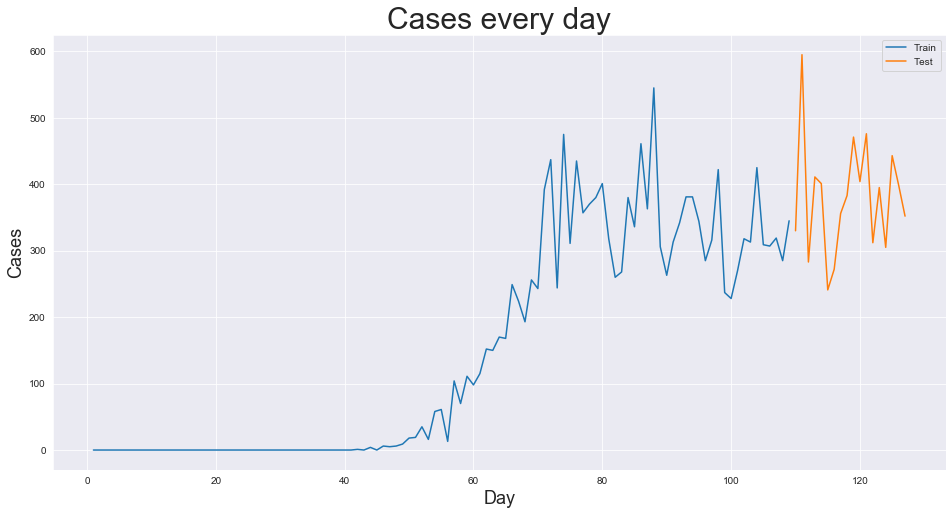

In [43]:
# Direct chart of cases
plt.figure(figsize=(16,8))
plt.title('Cases every day', fontsize=30)
# train data
plt.plot(df_cases_PL_train['T'],df_cases_PL_train['TargetValue'], label='Train')
# test data
plt.plot(df_cases_PL_test['T'],df_cases_PL_test['TargetValue'], label='Test')
plt.legend()
plt.xlabel('Day', fontsize=18)
plt.ylabel('Cases', fontsize=18)
plt.show()

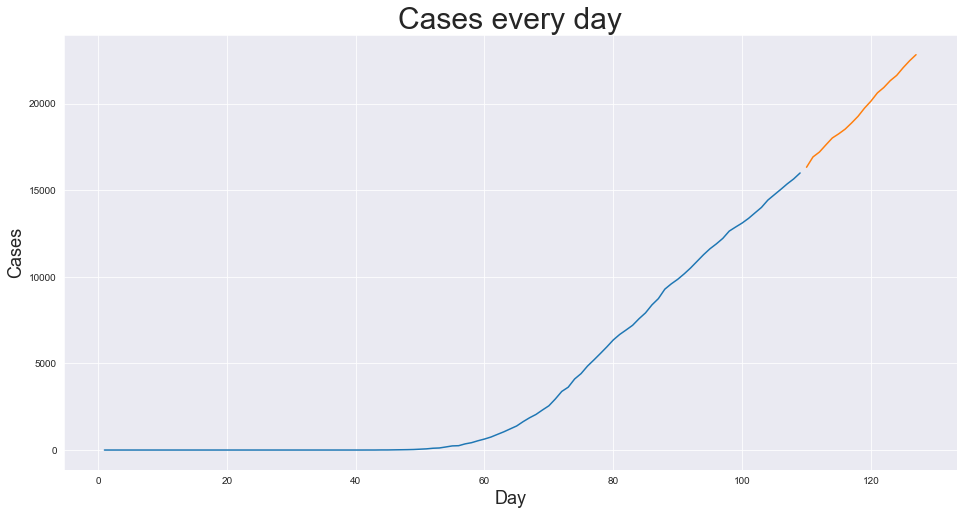

In [44]:
# Cumulative chart of cases
plt.figure(figsize=(16,8))
plt.title('Cases every day', fontsize=30)
# train data 
plt.plot(df_cases_PL_train['T'],df_cases_PL_train['CSUM'])
# test data
plt.plot(df_cases_PL_test['T'],df_cases_PL_test['CSUM'])
plt.xlabel('Day', fontsize=18)
plt.ylabel('Cases', fontsize=18)
plt.show()

We can observe that sumulative chart is in case of poland very simple. One can easily try to predict oncomming days just by linear regression.

#### FATAL CASES

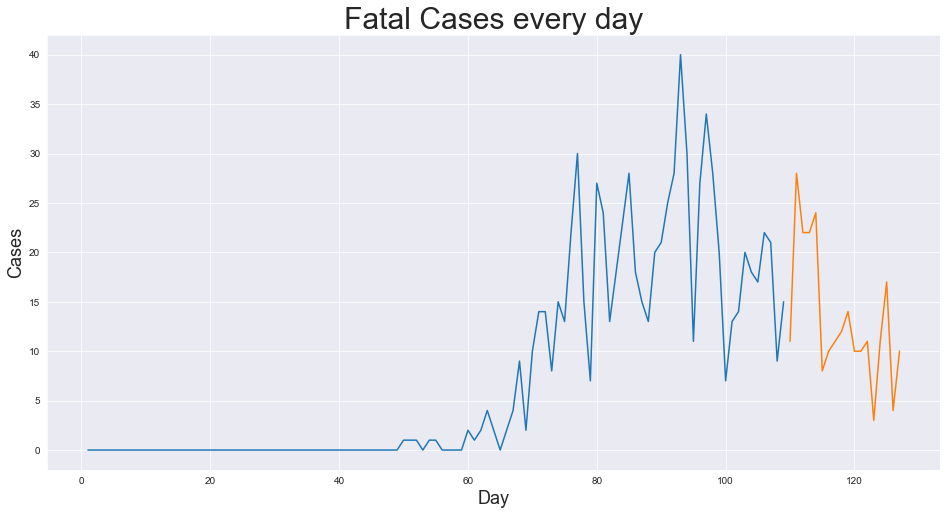

In [45]:
# Direct chart of cases
plt.figure(figsize=(16,8))
plt.title('Fatal Cases every day', fontsize=30)
# train data
plt.plot(df_fatal_PL_train['T'],df_fatal_PL_train['TargetValue'])
# test data
plt.plot(df_fatal_PL_test['T'],df_fatal_PL_test['TargetValue'])
plt.xlabel('Day', fontsize=18)
plt.ylabel('Cases', fontsize=18)
plt.show()

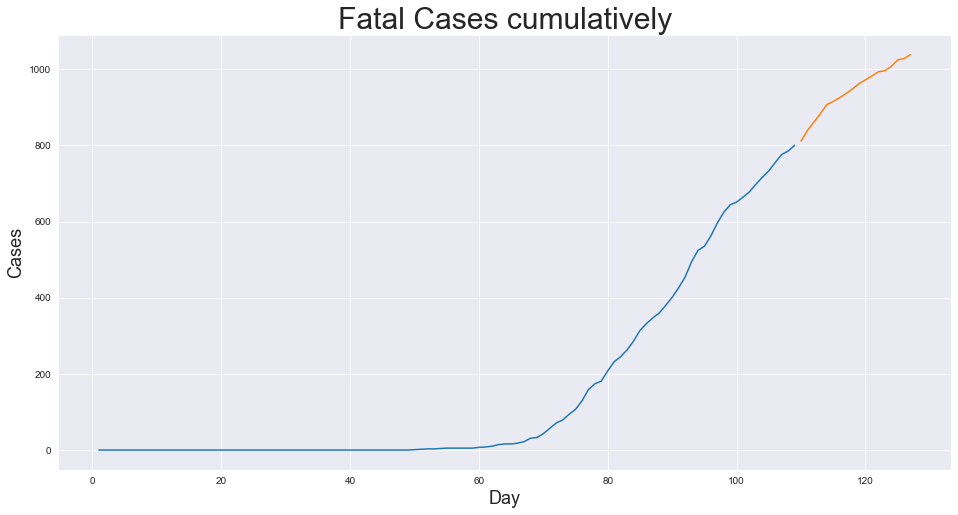

In [46]:
# Cumulative chart of cases
plt.figure(figsize=(16,8))
plt.title('Fatal Cases cumulatively', fontsize=30)
# train data
plt.plot(df_fatal_PL_train['T'],df_fatal_PL_train['CSUM'])
# test data
plt.plot(df_fatal_PL_test['T'],df_fatal_PL_test['CSUM'])
plt.xlabel('Day', fontsize=18)
plt.ylabel('Cases', fontsize=18)
plt.show()

Shape of fatal cases plot is different, one can easily see that simple linear regression will not satisfy the problem.

## Modeling

## SVM - regression
Function will compare three SVM ragression systems with different kernels, linear, polynomial and radial.

In [47]:
def predict_values_SVR(X_train, y_train, X_test, y_test):
    
    # Create 3 SVRM with different kernels
    svr_lin = SVR(kernel='linear', C=1e3)
    svr_sig = SVR(kernel='sigmoid', C=1e3)
    svr_pol = SVR(kernel='poly', C=1e3, degree=3)
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.01)
    
    # Train all models
    svr_lin.fit(X_train, y_train)
    #svr_sig.fit(X_train, y_train)
    svr_pol.fit(X_train, y_train)
    svr_rbf.fit(X_train, y_train)
    
    # Plotting on training data to check which model fits best 
    plt.figure(figsize=(16,8))
    plt.title('Cases every day (model predictions SVM) TRAIN DATA', fontsize=30)
    # training data
    plt.plot(X_train, y_train, color='black', label='Training Data')
    # linear prediction
    plt.plot(X_train, svr_lin.predict(X_train), color='red', label='Linear Model')
    # sigmoidal prediction 
    #plt.plot(X_train, svr_sig.predict(X_train), color='orange', label='Sigmoidal Model')   
    # polynomial prediction
    plt.plot(X_train, svr_pol.predict(X_train), color='green', label='Polynomial Model')    
    # radial prediction 
    plt.plot(X_train, svr_rbf.predict(X_train), color='blue', label='RBF Model')   
    plt.legend()
    plt.xlabel('Day', fontsize=18)
    plt.ylabel('Cases', fontsize=18)
    plt.show()
    
    # Training mark Metrics
    print('TRAINING')
    print('RMSE')
    print('Linear prediction:')
    print(np.sqrt(metrics.mean_squared_error(y_train, svr_lin.predict(X_train))))
    print('Polynomial prediction:')
    print(np.sqrt(metrics.mean_squared_error(y_train, svr_pol.predict(X_train))))
    print('RBF prediction:')
    print(np.sqrt(metrics.mean_squared_error(y_train, svr_rbf.predict(X_train))))
    print('\nMAE')
    print('Linear prediction:')
    print(metrics.mean_absolute_error(y_train, svr_lin.predict(X_train)))
    print('Polynomial prediction:')
    print(metrics.mean_absolute_error(y_train, svr_pol.predict(X_train)))
    print('RBF prediction:')
    print(metrics.mean_absolute_error(y_train, svr_rbf.predict(X_train)))
    
    
    #### Plotting test data
    # Plotting on training data to check which model fits best 
    plt.figure(figsize=(16,8))
    plt.title('Cases every day (model predictions SVM) TEST DATA', fontsize=30)
    #### training data
    plt.plot(X_train, y_train, color='black', label='Training Data', alpha = 0.2)
    # linear prediction train
    plt.plot(X_train, svr_lin.predict(X_train), color='red', label='Linear Model (train)', alpha = 0.2)
    # sigmoidal prediction 
    #plt.plot(X_train, svr_sig.predict(X_train), color='orange', label='Sigmoidal Model', alpha = 0.2)
    # polynomial prediction train
    plt.plot(X_train, svr_pol.predict(X_train), color='green', label='Polynomial Model (train)', alpha = 0.2)    
    # radial prediction train
    plt.plot(X_train, svr_rbf.predict(X_train), color='blue', label='RBF Model (train)', alpha = 0.2)
    #### testing data
    plt.plot(X_test, y_test, color='black', label='Testing Data')
    # linear prediction TEST
    plt.plot(X_test, svr_lin.predict(X_test), color='red', label='Linear Model (test)')
    # sigmoidal prediction 
    #plt.plot(X_test, svr_sig.predict(X_test), color='orange', label='Sigmoidal Model')
    # polynomial prediction TEST
    plt.plot(X_test, svr_pol.predict(X_test), color='green', label='Polynomial Model (test)')    
    # radial prediction TEST
    plt.plot(X_test, svr_rbf.predict(X_test), color='blue', label='RBF Model (test)')   
    plt.legend()
    plt.xlabel('Day',fontsize = 18)
    plt.ylabel('Cases',fontsize = 18)
    plt.show()
    
    # Testing mark Metrics
    print('TESTING')
    print('RMSE')
    print('Linear prediction:')
    print(np.sqrt(metrics.mean_squared_error(y_test, svr_lin.predict(X_test))))
    print('Polynomial prediction:')
    print(np.sqrt(metrics.mean_squared_error(y_test, svr_pol.predict(X_test))))
    print('RBF prediction:')
    print(np.sqrt(metrics.mean_squared_error(y_test, svr_rbf.predict(X_test))))
    print('\nMAE')
    print('Linear prediction:')
    print(metrics.mean_absolute_error(y_test, svr_lin.predict(X_test)))
    print('Polynomial prediction:')
    print(metrics.mean_absolute_error(y_test, svr_pol.predict(X_test)))
    print('RBF prediction:')
    print(metrics.mean_absolute_error(y_test, svr_rbf.predict(X_test)))
    
    # Return all three models predictions
    return svr_lin.predict(X_test), svr_pol.predict(X_test), svr_rbf.predict(X_test)
    

### Testing method on CumulativeSum of fatalities

In [48]:
# data needed reshaping indto 2D array
X_train = np.array(df_fatal_PL_train['T']).reshape(train_samples, 1)
y_train = np.array(df_fatal_PL_train['CSUM']).reshape(train_samples, 1)
X_test = np.array(df_fatal_PL_test['T']).reshape(test_samples, 1)
y_test = np.array(df_fatal_PL_test['CSUM']).reshape(test_samples, 1)

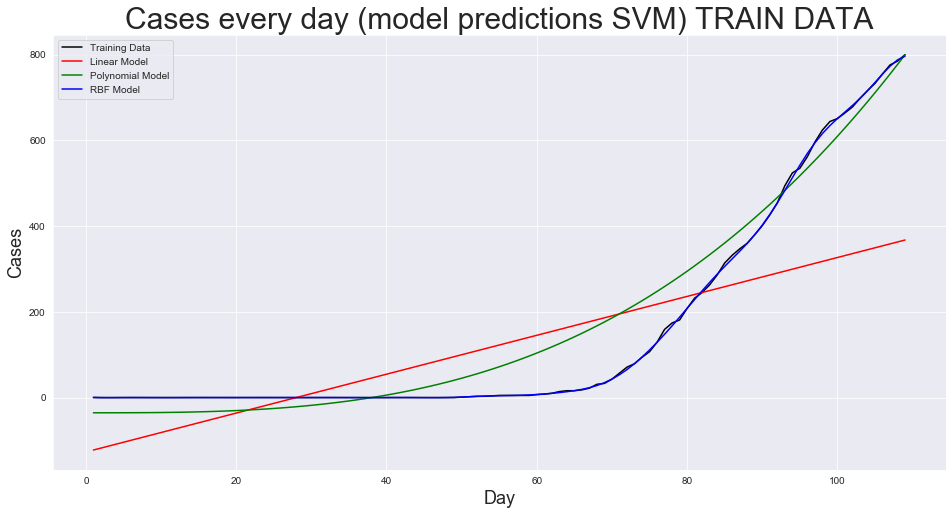

TRAINING
RMSE
Linear prediction:
157.6305545385281
Polynomial prediction:
63.524703565779774
RBF prediction:
3.1709444111737564

MAE
Linear prediction:
118.6110091742051
Polynomial prediction:
49.857751791501194
RBF prediction:
1.5758461915511195


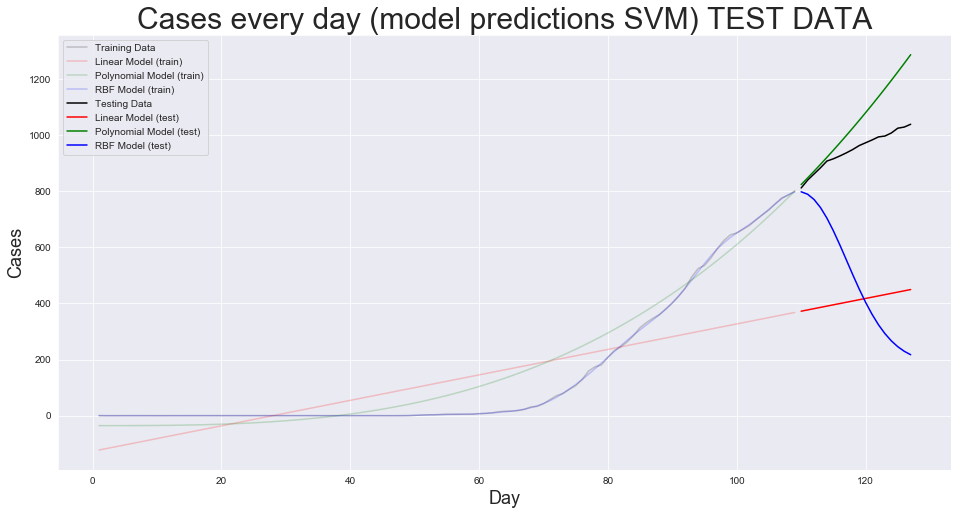

TESTING
RMSE
Linear prediction:
536.8835088743235
Polynomial prediction:
125.9717891300416
RBF prediction:
524.8418760712226

MAE
Linear prediction:
535.2425925924092
Polynomial prediction:
98.12287828963879
RBF prediction:
450.4773195523953


In [49]:
# using function to predict possible values
predicted_fatals = predict_values_SVR(X_train, y_train, X_test, y_test)

### Testing metod on every day fatalities

In [50]:
# data needed reshaping indto 2D array
X_train = np.array(df_fatal_PL_train['T']).reshape(train_samples, 1)
y_train = np.array(df_fatal_PL_train['TargetValue']).reshape(train_samples, 1)
X_test = np.array(df_fatal_PL_test['T']).reshape(test_samples, 1)
y_test = np.array(df_fatal_PL_test['TargetValue']).reshape(test_samples, 1)

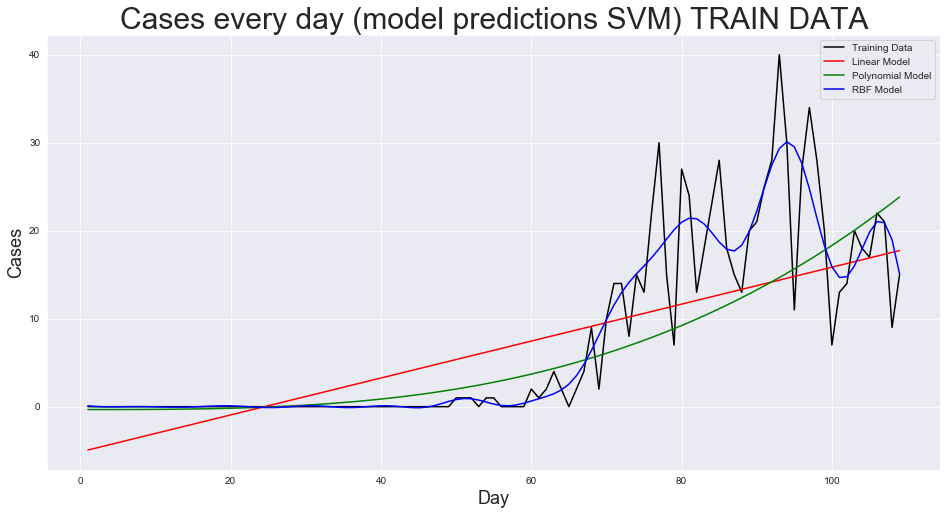

TRAINING
RMSE
Linear prediction:
6.586848020810717
Polynomial prediction:
6.447525802070411
RBF prediction:
3.744005220248045

MAE
Linear prediction:
4.895356212714733
Polynomial prediction:
3.7842276790198857
RBF prediction:
1.75647600208981


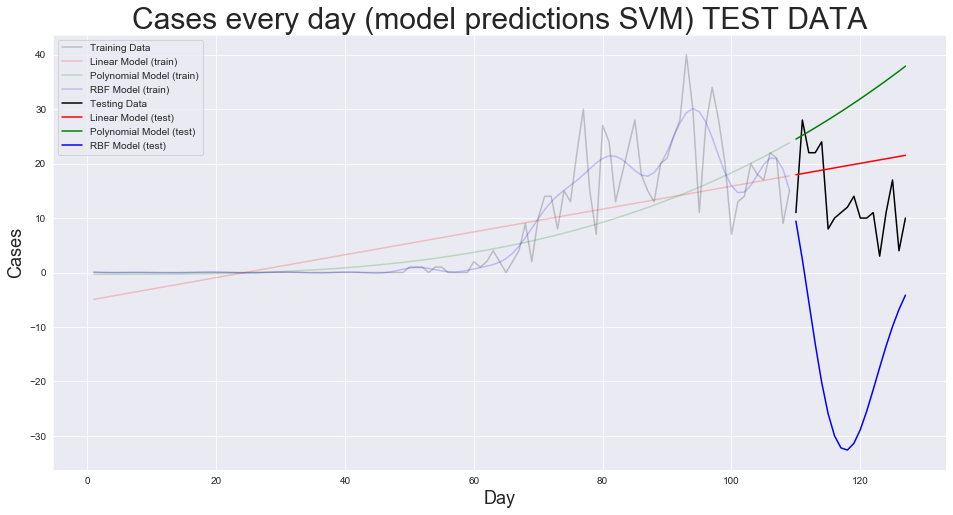

TESTING
RMSE
Linear prediction:
9.778616973682919
Polynomial prediction:
20.097047219016392
RBF prediction:
32.60875076840308

MAE
Linear prediction:
8.967078191656098
Polynomial prediction:
17.979365456235605
RBF prediction:
30.25411925104767


In [51]:
# using function to predict possible values
predicted_fatals = predict_values_SVR(X_train, y_train, X_test, y_test)

One can try to use data from the moment when characteristic is starting to rise, the 0 values may introduse some kind of noise to the model.

In [52]:
# data needed reshaping indto 2D array
X_train = np.array(df_fatal_PL_train['T']).reshape(train_samples, 1)[70:]
y_train = np.array(df_fatal_PL_train['CSUM']).reshape(train_samples, 1)[70:]
X_test = np.array(df_fatal_PL_test['T']).reshape(test_samples, 1)
y_test = np.array(df_fatal_PL_test['CSUM']).reshape(test_samples, 1)

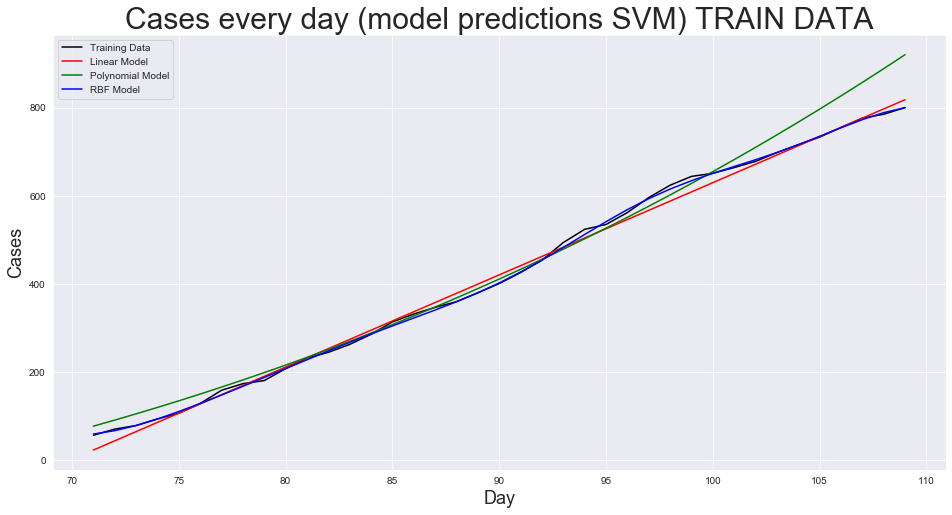

TRAINING
RMSE
Linear prediction:
15.684244700511357
Polynomial prediction:
36.807249322448484
RBF prediction:
5.206547421645004

MAE
Linear prediction:
12.240544871635219
Polynomial prediction:
24.333041521456643
RBF prediction:
3.7520946194481004


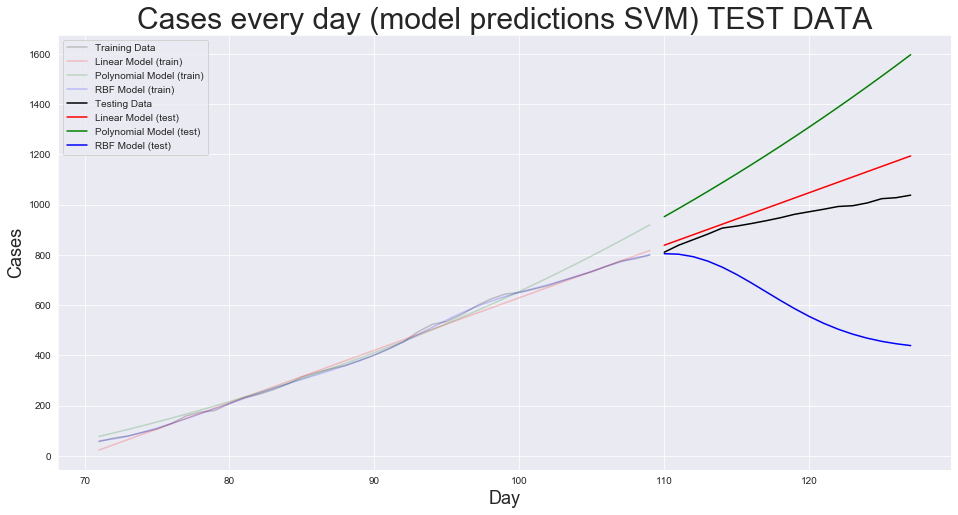

TESTING
RMSE
Linear prediction:
84.26632446890164
Polynomial prediction:
341.7699615980007
RBF prediction:
383.84287575583136

MAE
Linear prediction:
70.57743055408916
Polynomial prediction:
314.3628421297777
RBF prediction:
330.2883828074571


In [53]:
# using function to predict possible values
predicted_fatals = predict_values_SVR(X_train, y_train, X_test, y_test)

Polynomial, linear - Created models are very simple due to the type of the nauron used in this prediction, it is impossible to predict any type of changes in the future data (the work almost as simple Linear Regression)

RBF - While it is great in the field we are trainning it in, due to the characteristic of RBF kernel, when we move out of the gamma field, the redictions are getting useless. The function of RBF neuron is a local Gaussian function, so the parameter gamma will decide how far from the center it is activated. Due to no training in area od testing data, no neuron was train to predict there, due to this fact, training metrics are great, and testing metrics are awfull.

The idea od using SVM is nice, and from my experience often used in such problems, but on simple models, and only for short predistions, or insige the training area but between training samples. Unfortunately in this case it is not workin to well, that is why the memory approach might work much better, based on previous n steps it might be much easier to create usefull model.

## LSTM - long short term memory
After implementing very simple model it is obvious, that the praediction based on previous values is required. LSTM is using input from past tries to try to predict the upcomming days.

The data X_train and X_test is going to be n days data, and correlated y_train and y_test data is going to be the next day after the n of 'X-es'

Using LSTM in daily fatal cases is useless, there is no direction that can be forseen, due to this fact we are only using CSUM column in this case

In [54]:
# data - general data set, prediction is differen than before, so the preparation is inside function
# train_size (0-1) - train/test split, 0.8
# n - ilość powtórzonych procesów uczenia, 1
# n_samples - how many previous samples are used in process of prediction, 20
# opt_engine - the optimization algorithm used in training, 'Adam'
def predict_values_LSTM(data, train_size=0.8, n=1, n_samples=20, opt_engine='Adam'):


    # converting it to numpy
    dataset = data.values
    # similarly trainning data is going to be first 109 samples, this value is taken from previous trainning datasets
    training_data_len = math.ceil(len(dataset)*train_size)
    
    # to make the prediction easier scaling is done (0,1)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    
    # creating training data
    train_data = scaled_data[0:training_data_len,:]

    # split data into x_train and y_train where x is some amont of samples and the next is y
    x_train = []
    y_train = []

    # number of samples used for predisting y
    n_samples = 20
    
    # training data creation
    for i in range(n_samples, len(train_data)):
        x_train.append(train_data[i-n_samples:i, 0])
        y_train.append(train_data[i,0])

    # Convert x_train y_train to np.array
    x_train, y_train = np.array(x_train), np.array(y_train)
    # reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
            
    # Build the model 
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    # compile the model
    model.compile(optimizer=opt_engine, loss='mean_squared_error')    
    
    # model trainning
    model.fit(x_train, y_train, batch_size=1, epochs=n, verbose=0)
        
    # Create the testing data
    test_data = scaled_data[training_data_len-n_samples:,:]

    # create x_test and y_test 
    x_test = []
    y_test = dataset[training_data_len:,:]
    for i in range(n_samples, len(test_data)):
        x_test.append(test_data[i-n_samples:i,0])  
    
    # convert data into np.array
    x_test = np.array(x_test)
    # reshape the data 
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    # models predictions 
    # training data
    predictions_train = model.predict(x_train)
    predictions_train = scaler.inverse_transform(predictions_train)
    
    # test data
    predictions_test = model.predict(x_test)
    predictions_test = scaler.inverse_transform(predictions_test)
    
    # assesing the model 
    print('Training model')
    print('RSME')
    print(np.sqrt(metrics.mean_squared_error(y_train, predictions_train)))
    print('MAE')
    print(metrics.mean_absolute_error(y_train, predictions_train))
    
    print('\nTesting model')
    print('RSME')
    print(np.sqrt(metrics.mean_squared_error(y_test, predictions_test)))
    print('MAE')
    print(metrics.mean_absolute_error(y_test, predictions_test))
    
    # Plotting data 
    train = data[n_samples:training_data_len]
    train['Predictions'] = predictions_train
    valid = data[training_data_len:]
    valid['Predictions'] = predictions_test
    
    # Visualize the data
    plt.figure(figsize = (16,8))
    plt.title('Models predictions', fontsize=30)
    plt.xlabel('Date' ,fontsize = 18)
    plt.ylabel('Fatalities',fontsize = 18)
    plt.plot(train[train.columns[0]], color='black', alpha = 0.5, label='Training Data')
    plt.plot(train['Predictions'], color='red', alpha = 0.5, label='Predistions Training')
    plt.plot(valid[valid.columns[0]], color='black', label='Testing Data')
    plt.plot(valid['Predictions'], color='red', label='Predistions Testing')
    plt.legend(loc = 'lower right')
    plt.gcf().autofmt_xdate()
    plt.show()


Training model
RSME
363.9614175550479
MAE
214.97227170318078

Testing model
RSME
18.242318718315413
MAE
17.124069213867188


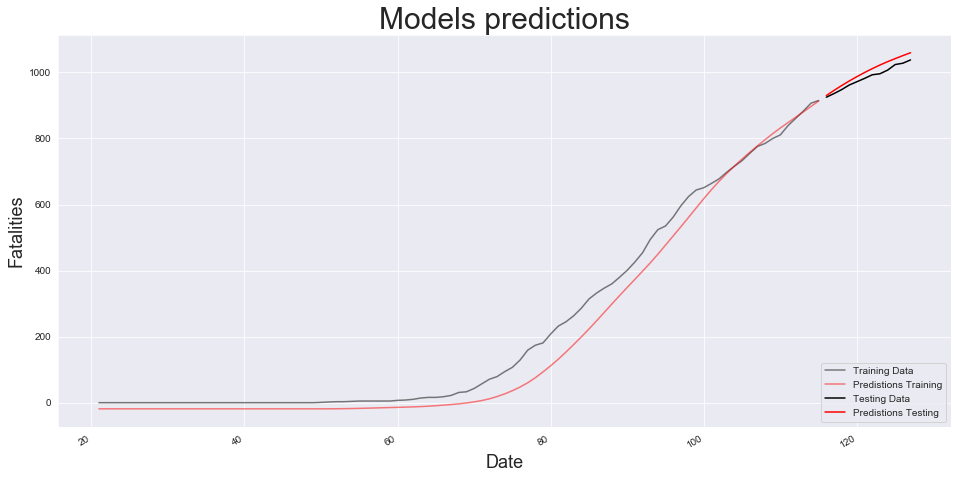

In [55]:
# dataframe with only CSUM
data = df_fatal_PL.filter(['CSUM']) 
T = list(range(1,data.shape[0]+1))
data['T'] = T
data.set_index('T', inplace=True)

predict_values_LSTM(data, train_size = 0.9, n = 3, n_samples = 20, opt_engine = 'Adam')

Training model
RSME
13.634123253413264
MAE
9.99159627964622

Testing model
RSME
7.4978859744231885
MAE
6.871831893920898


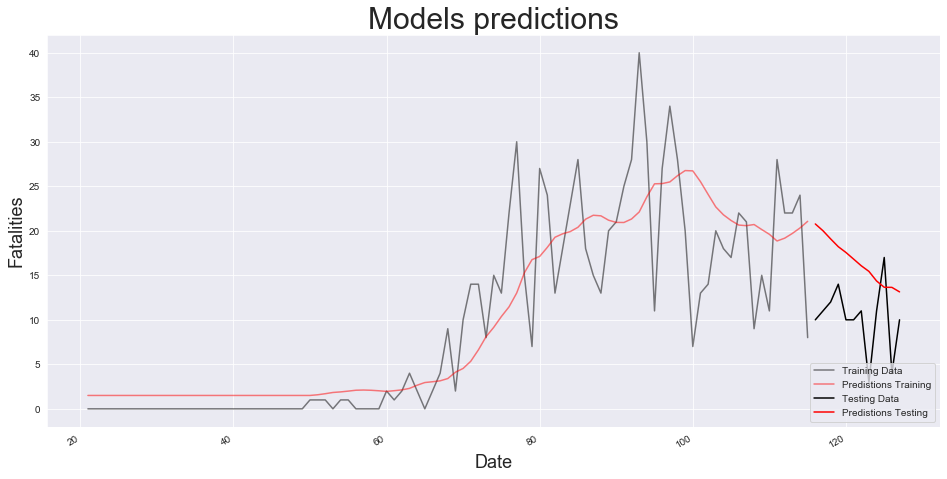

In [56]:
# dataframe with only daily fatals
# dataframe with only CSUM
data = df_fatal_PL.filter(['TargetValue']) 
T = list(range(1,data.shape[0]+1))
data['T'] = T
data.set_index('T', inplace=True)

predict_values_LSTM(data, train_size = 0.9, n = 3, n_samples = 20, opt_engine = 'Adam')

I comparison with other methods, training results are somewhat worse, but testing results are far more better, than other methods. It is caused by iterative approach, the data might be predicted better if there was more information from other countries.

In [57]:
opt_engines = ['SGD','RMSprop','Adam','Adadelta','Adagrad','Adamax','Nadam','Ftrl']

### European way (similar to Pland)
Other route we could take is not assesing similar countries, but we could try going the route of european counties
so try to combine data from whole europe in order to predict the future fatal cases.

In [58]:
similar_PL = ['SWE', 'FIN', 'ROU', 'AUT', 'CHE', 'IRL', 'PRT', 'CZE', 'HUN', 'POL']

In [59]:
# countries_table - table of ISO codes that should take part in training
def predict_values_LSTM(countries_table, train_size=0.8, n=1, n_samples=20, opt_engine='Adam', data_type=1):   
    itera = False
    
    for country in countries_table:
        # creating polish datasets
        data = df_fatal[df_fatal['Country_Code'] == country]
        # dropping country code
        data.drop(['Country_Code'], axis=1, inplace=True)
        # dropping country
        data.drop(['Country'], axis=1, inplace=True)
        # adding T column representing dates as iterative numbers
        T = list(range(1,data.shape[0]+1))
        data['T'] = T
        data.set_index('T', inplace=True)
        data['CSUM'] = np.cumsum(data['TargetValue'])
        
        if data_type == 1:
            data = data.filter(['CSUM']) 
        else:
            data = data.filter(['TargetValue'])
            
        # converting it to numpy
        dataset = data.values
        # similarly trainning data is going to be first 109 samples, this value is taken from previous trainning datasets
        training_data_len = math.ceil(len(dataset)*train_size)

        # to make the prediction easier scaling is done (0,1)
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(dataset)

        # creating training data
        train_data = scaled_data[0:training_data_len,:]

        # split data into x_train and y_train where x is some amont of samples and the next is y
        x_train = []
        y_train = []

        # number of samples used for predisting y
        n_samples = 20

        # training data creation
        for i in range(n_samples, len(train_data)):
            x_train.append(train_data[i-n_samples:i, 0])
            y_train.append(train_data[i,0])

        # Convert x_train y_train to np.array
        x_train, y_train = np.array(x_train), np.array(y_train)
        # reshape the data
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


        if itera == False:
            # Build the model 
            model = Sequential()
            model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
            model.add(LSTM(50, return_sequences=False))
            model.add(Dense(25))
            model.add(Dense(1))
            # compile the model
            model.compile(optimizer=opt_engine, loss='mean_squared_error')
            itera = True

        # model trainning
        model.fit(x_train, y_train, batch_size=1, epochs=n, verbose=0)

    # Create the testing data
    test_data = scaled_data[training_data_len-n_samples:,:]

    # create x_test and y_test 
    x_test = []
    y_test = dataset[training_data_len:,:]
    for i in range(n_samples, len(test_data)):
        x_test.append(test_data[i-n_samples:i,0])  

    # convert data into np.array
    x_test = np.array(x_test)
    # reshape the data 
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # models predictions 
    # training data
    predictions_train = model.predict(x_train)
    predictions_train = scaler.inverse_transform(predictions_train)

    # test data
    predictions_test = model.predict(x_test)
    predictions_test = scaler.inverse_transform(predictions_test)

    # assesing the model 
    print('Training model')
    print('RSME')
    print(np.sqrt(metrics.mean_squared_error(y_train, predictions_train)))
    print('MAE')
    print(metrics.mean_absolute_error(y_train, predictions_train))

    print('\nTesting model')
    print('RSME')
    print(np.sqrt(metrics.mean_squared_error(y_test, predictions_test)))
    print('MAE')
    print(metrics.mean_absolute_error(y_test, predictions_test))

    # Plotting data 
    train = data[n_samples:training_data_len]
    train['Predictions'] = predictions_train
    valid = data[training_data_len:]
    valid['Predictions'] = predictions_test

    # Visualize the data
    plt.figure(figsize = (16,8))
    plt.title('Models predictions, epochs = {:d}'.format(n), fontsize=30)
    plt.xlabel('Date', fontsize = 18)
    plt.ylabel('Fatalities', fontsize = 18)
    plt.plot(train[train.columns[0]], color='black', alpha = 0.5, label = 'Training Data')
    plt.plot(train['Predictions'], color='red', alpha = 0.5, label = 'Training Prediction')
    plt.plot(valid[valid.columns[0]], color='black', label = 'Testing Data')
    plt.plot(valid['Predictions'], color='red', label = 'Testing Predistions')
    plt.legend(loc = 'lower right')
    
    return model

Można pozmieniać ilość epok, ale widać, ze większa ilość danych zdecydowanie pozytywnie wpływa na działanie sieci, to jest oczywiste.

Training model
RSME
250.42147544698372
MAE
138.73539444490888

Testing model
RSME
77.83052257649304
MAE
68.36782958984375


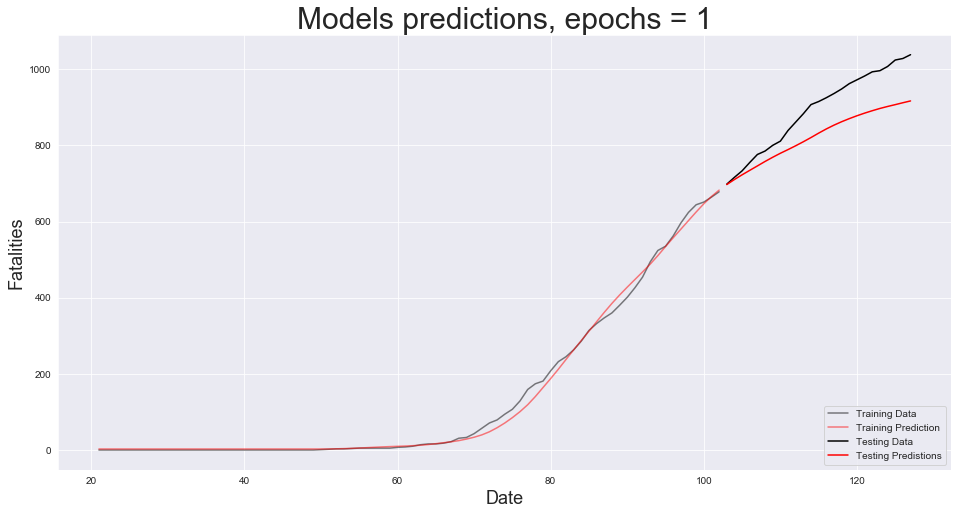

In [60]:
predict_values_LSTM(similar_PL, train_size=0.8, n=1, n_samples=20, opt_engine='Adam', data_type=1)

Training model
RSME
244.55854253007917
MAE
136.07448130240147

Testing model
RSME
64.51616998915786
MAE
59.200732421875


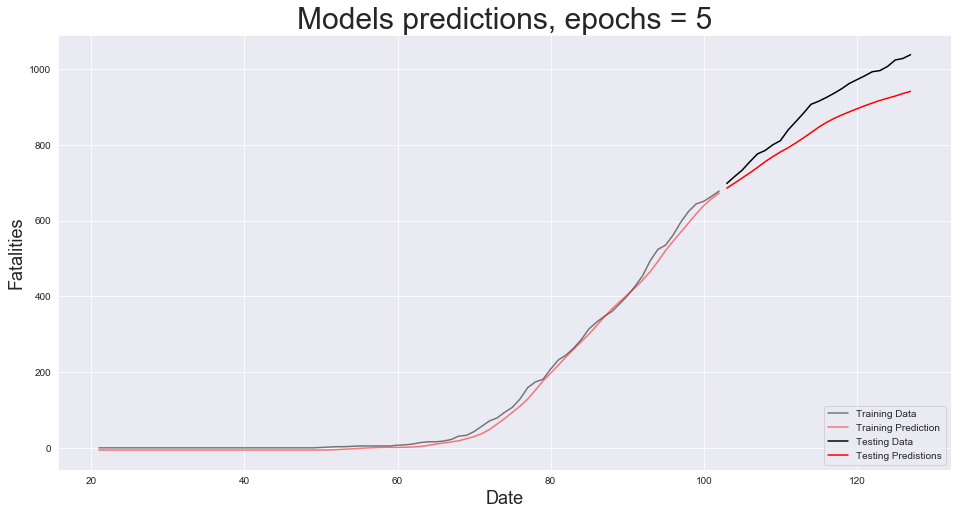

In [61]:
predict_values_LSTM(similar_PL, train_size=0.8, n=5, n_samples=20, opt_engine='Adam', data_type=1)

Training model
RSME
13.261301209311414
MAE
8.291751365581664

Testing model
RSME
6.473166667124808
MAE
5.346906585693359


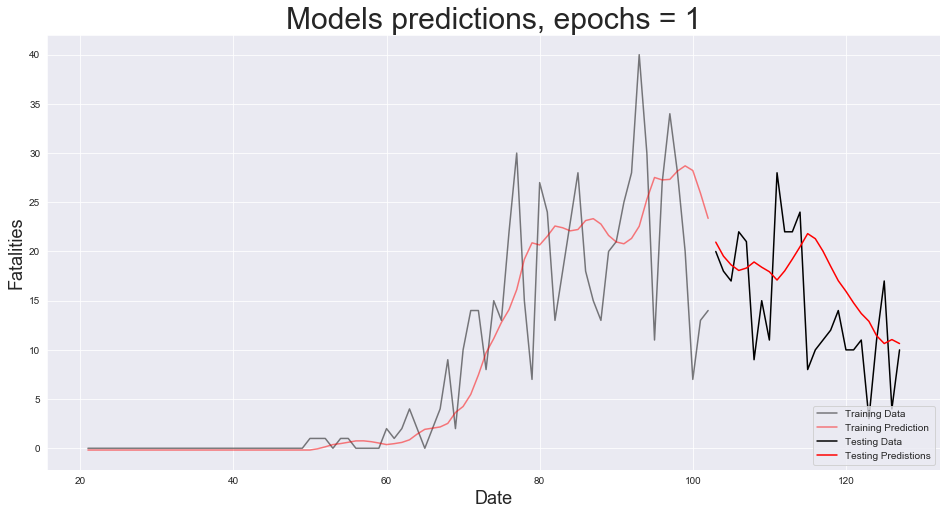

In [62]:
predict_values_LSTM(similar_PL, train_size=0.8, n=1, n_samples=20, opt_engine='Adam', data_type=2)

Training model
RSME
11.942944010593218
MAE
8.143275284185641

Testing model
RSME
6.560007920676457
MAE
5.594641647338867


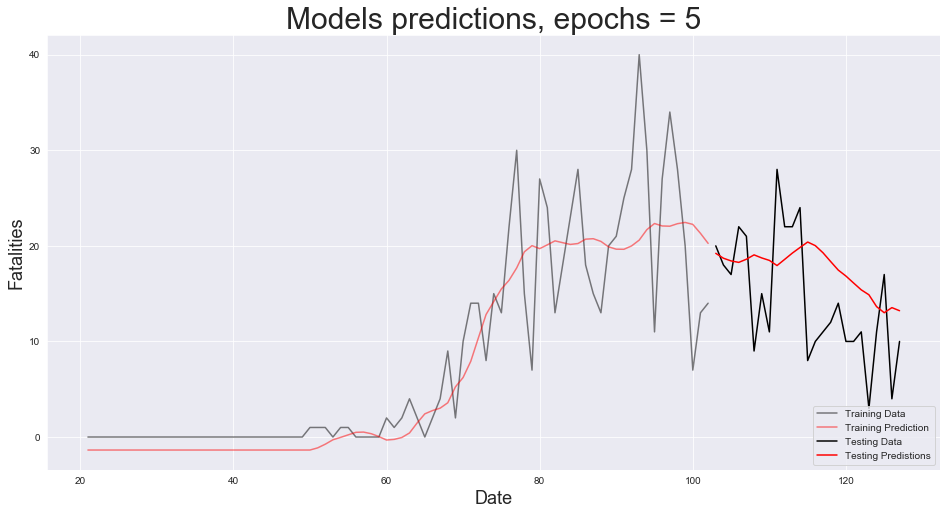

In [63]:
predict_values_LSTM(similar_PL, train_size=0.8, n=5, n_samples=20, opt_engine='Adam', data_type=2)

# Europe way (ALL)
thanks to the generalization properties of neural networks it might be good to teach the network on as much data it is possible, it should manage to choose the most important parts by itself.

Training model
RSME
253.89577455282438
MAE
140.82388108144792

Testing model
RSME
40.26876502985002
MAE
34.41662353515625


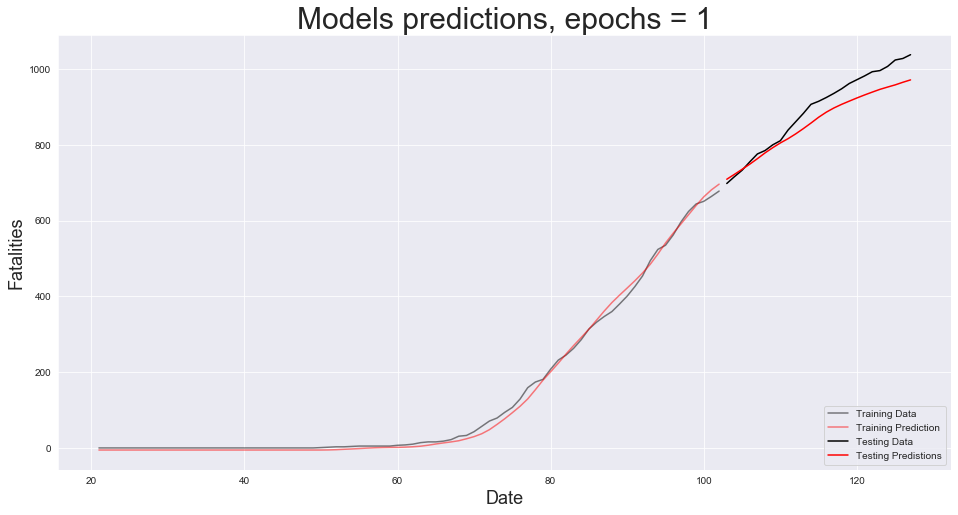

In [64]:
predict_values_LSTM(countries_EU_ISO, train_size=0.8, n=1, n_samples=20, opt_engine='Adam', data_type=1)

Training model
RSME
251.27824618571233
MAE
140.24006607886744

Testing model
RSME
23.747716536732305
MAE
20.00102783203125


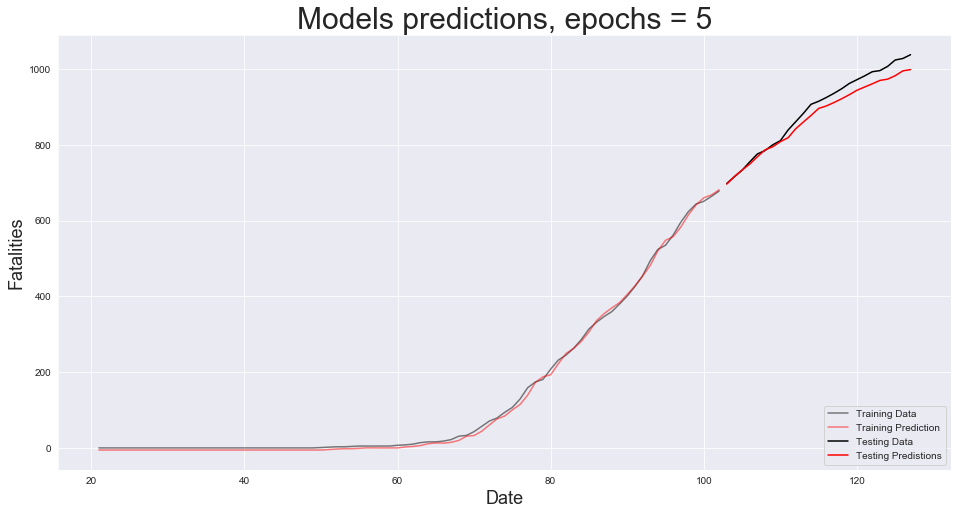

In [65]:
predict_values_LSTM(countries_EU_ISO, train_size=0.8, n=5, n_samples=20, opt_engine='Adam', data_type=1)

Training model
RSME
12.11994827230382
MAE
7.983372405389458

Testing model
RSME
6.151859450206295
MAE
4.937746772766113


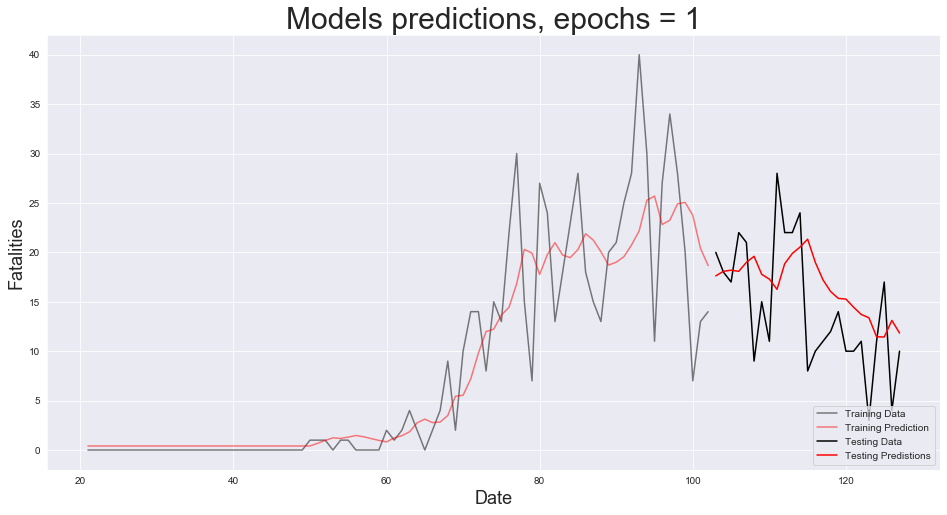

In [66]:
predict_values_LSTM(countries_EU_ISO, train_size=0.8, n=1, n_samples=20, opt_engine='Adam', data_type=2)

Training model
RSME
12.622201923894494
MAE
8.601187629525253

Testing model
RSME
6.734903241688433
MAE
5.67770866394043


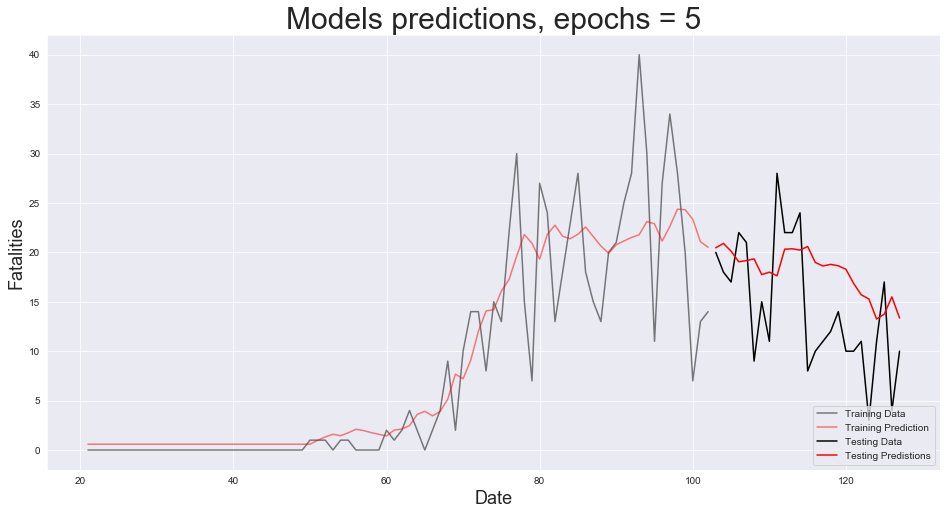

In [67]:
predict_values_LSTM(countries_EU_ISO, train_size=0.8, n=5, n_samples=20, opt_engine='Adam', data_type=2)

One can easily see that more data is better data :)

# World way

In [68]:
countries_world = df_fatal['Country_Code'].unique()

In [69]:
countries_world = list(countries_world)
countries_world.append('POL')

Training model
RSME
251.5091272210071
MAE
140.005352632803

Testing model
RSME
29.710721868589655
MAE
25.1526220703125


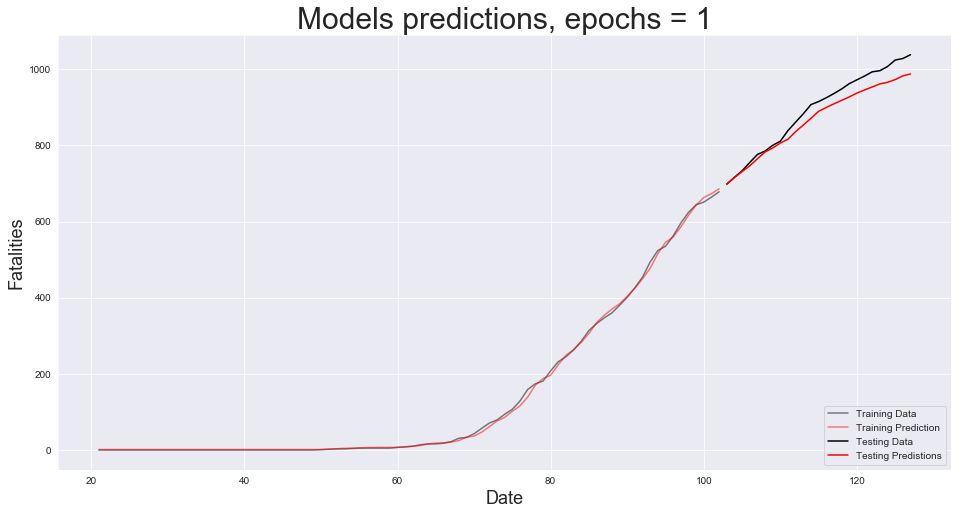

In [70]:
#predict_values_LSTM(countries_world, train_size=0.8, n=1, n_samples=20, opt_engine='Adam', data_type=1)

Training model
RSME
13.406803562032112
MAE
9.066121732897873

Testing model
RSME
10.770817756412734
MAE
9.267511291503906


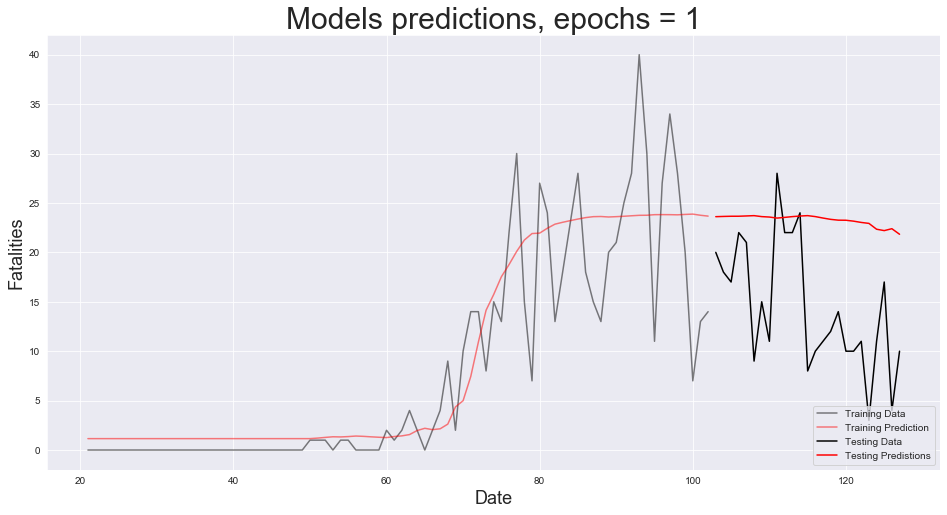

In [71]:
#predict_values_LSTM(countries_world, train_size=0.8, n=1, n_samples=20, opt_engine='Adam', data_type=2)

Training model
RSME
252.36293471846304
MAE
142.3886057913956

Testing model
RSME
24.28450365187387
MAE
20.01763916015625


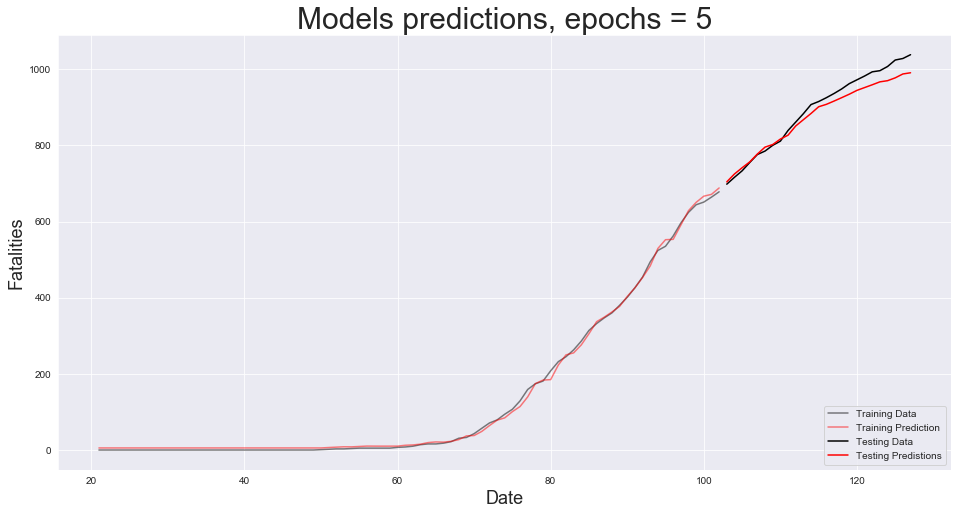

In [72]:
#predict_values_LSTM(countries_world, train_size=0.8, n=5, n_samples=20, opt_engine='Adam', data_type=1)

As predicted, although the data is not necesairly corelated with Poland situation, its sheer amount is enought to allow the predictor to run much better. Both daily and cumulative predictions are far more precise.
Although, the data from whole coutry resulted in worst predictions than pure EU, it might be due to bad samples form countries where diagnostics is not on high enough level.